# Idenidentification Game with ResNet152

### initialization

In [22]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


#### Prepare for Plotting

In [23]:
!pip install pycm livelossplot
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['test', 'indices', 'Normalize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
import torch
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from livelossplot import PlotLosses
from pycm import *
import torch.nn as nn
import torch.nn.functional as F

### Initialise dataset
These files are prepared in advance since it takes much time to transform imgs to Tensors.

In [25]:
X_train_all = torch.load('/content/gdrive/My Drive/Kaggle/Copy of X_train_all.py') # all images in train file
y_train_all = torch.load('/content/gdrive/My Drive/Kaggle/Copy of y_train_all.py') # all labels in train file
mean_list = torch.tensor([0.4802, 0.4481, 0.3975])
std_list =torch.tensor([0.2770, 0.2691, 0.2821])
print(mean_list)
print(std_list)
print(X_train_all.shape)
print(y_train_all.shape)

tensor([0.4802, 0.4481, 0.3975])
tensor([0.2770, 0.2691, 0.2821])
torch.Size([100000, 3, 64, 64])
torch.Size([100000])


#### Sanity check

In [26]:
print(X_train_all.max(), X_train_all.min())

tensor(1.) tensor(0.)


Stratify the dataset

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42) 
spt = sss.split(X_train_all, y_train_all)
# get the indices of the splited data
indices = [(train_idx, validation_idx) for train_idx, validation_idx in spt][0]

In [28]:
# here the dataset is still in the form of np.array
X_train, y_train = X_train_all[indices[0]], y_train_all[indices[0]]
X_val, y_val = X_train_all[indices[1]], y_train_all[indices[1]]

#Check the size of the data set
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)
print(X_train.max())

torch.Size([90000, 3, 64, 64]) torch.Size([10000, 3, 64, 64])
torch.Size([90000]) torch.Size([10000])
tensor(1.)


### Create custom dataset

In [0]:
from torch.utils.data import Dataset
from PIL import Image

# Custom Dataset for performing Stratified Shuffle Split on ImageFolder datasets

class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            dataset: an ImageFolder containing the full set of data to be subsampled
            indices: array-like containing the stratified shuffle indices
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        # Note that samples are just paths to image files
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample, label

### Data-Arguementation
We resize the original pritures to 224*224 to fit the ResNet152 structure.

In [0]:
from torchvision.transforms import *

# Transformations

train_transform = Compose([ToPILImage(),
              transforms.Resize(224),
              RandomRotation(10),
              RandomHorizontalFlip(p=0.5),
              ToTensor(),
              Normalize(mean_list, std_list)])

#In Validation and Test Mode we only want to normalize our images
validation_test_transform = Compose(
    [ToPILImage(),
                    transforms.Resize(224),
                    ToTensor(),
                    Normalize(mean_list, std_list)])

### Create Dataloader for training and validation 

In [56]:
train_data = CustomDataset(X_train, y_train.long(), transform=train_transform)
val_data = CustomDataset(X_val, y_val.long(), transform=validation_test_transform)
train_all_data = CustomDataset(X_train_all, y_train_all.long(), transform=train_transform)

del X_train_all
del y_train_all

batch_size = 256
test_batch_size = 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=test_batch_size, shuffle=False, num_workers=2, pin_memory=True)
train_all_loader = torch.utils.data.DataLoader(train_all_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

NameError: ignored

## Initialize ResNet152
We choose the most advanced CNN which is trained on ImageNet. By fixing the whole layers, we add a new layer at the end, from 1000 classes to 200 classes. In this way, our new model's computational cost is acceptable, and the accuracy is expected to be good.

In [0]:
import torch.nn as nn
import torchvision.models as models

model = models.resnet152(pretrained=True)

for param in model.parameters():
  param.requires_grad = False

model = nn.Sequential(model, nn.Dropout(0.3), nn.ReLU(),  nn.Linear(1000,200))
model = model.cuda()


In [33]:
# show the structure of the updated model
model.eval()

Sequential(
  (0): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)



---



### Preparing for training session

In [0]:
# This part are computing the accuracy. It is able to compute top-1 and top-5 accuracy if needed.
class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self, name, fmt=':f'):
    self.name = name
    self.fmt = fmt
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

  def __str__(self):
    fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
    return fmtstr.format(**self.__dict__)

def accuracy(output, target, topk=(1,)):
  """Computes the accuracy over the k top predictions for the specified values of k"""
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
    res.append(correct_k.mul_(100.0 / batch_size))
  return res

        
def train(train_loader, model, criterion, optimizer, liveloss):
  batch_time = AverageMeter('Time', ':6.3f')
  data_time = AverageMeter('Data', ':6.3f')
  losses = AverageMeter('Loss', ':.4e')
  top1 = AverageMeter('Acc@1', ':6.2f')
  top5 = AverageMeter('Acc@5', ':6.2f')

  # We still use evaluation mode since we don't want to change any weights of the pretrained model. We only
  # need to change the weights of the added layer.
  model.eval()

  end = time.time()
  for i, (images, target) in enumerate(train_loader):
    # measure data loading time
    data_time.update(time.time() - end)
    images = images.cuda(non_blocking=True)
    target = target.cuda(non_blocking=True)

    # compute output
    output = model(images)
    loss = criterion(output, target)

    # measure accuracy and record loss
    acc1, acc5 = accuracy(output, target, topk=(1, 5))
    losses.update(loss.item(), images.size(0))
    top1.update(acc1[0], images.size(0))
    top5.update(acc5[0], images.size(0))

    # compute gradient and do SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # measure elapsed time
    batch_time.update(time.time() - end)
    end = time.time()

  liveloss.update({'loss':losses.avg, 'acc':top1.avg})
  liveloss.draw()
  return losses.avg, top1.avg

def validate(val_loader, model, criterion, liveloss):
  batch_time = AverageMeter('Time', ':6.3f')
  losses = AverageMeter('Loss', ':.4e')
  top1 = AverageMeter('Acc@1', ':6.2f')
  top5 = AverageMeter('Acc@5', ':6.2f')
  # switch to evaluate mode
  model.eval()
  with torch.no_grad():
    end = time.time()
    for i, (images, target) in enumerate(val_loader):
      images = images.cuda(non_blocking=True)
      target = target.cuda(non_blocking=True)
      # compute output
      output = model(images)
      loss = criterion(output, target)
      # measure accuracy and record loss
      acc1, acc5 = accuracy(output, target, topk=(1, 5))
      losses.update(loss.item(), images.size(0))
      top1.update(acc1[0], images.size(0))
      top5.update(acc5[0], images.size(0))
      # measure elapsed time
      batch_time.update(time.time() - end)
      end = time.time()
    liveloss.update({'val_loss':losses.avg, 'val_acc':top1.avg})
    liveloss.draw()
  return losses.avg, top1.avg


In [0]:
## train the model with validation data
# criterion = nn.CrossEntropyLoss()

# logs = {}
# liveloss = PlotLosses()
# for epoch in range(90):
#     train_loss, train_accuracy = train(train_loader, model, criterion, optimizer, liveloss)
    

#     # logs['' + 'log loss'] = train_loss
#     # logs['' + 'accuracy'] = train_accuracy

#     validation_loss, validation_accuracy = validate(val_loader, model, criterion, liveloss)
#     # logs['val_' + 'log loss'] = validation_loss
#     # logs['val_' + 'accuracy'] = validation_accuracy
#     scheduler.step()

#     liveloss.update(logs)
#     liveloss.draw()

## Train on the whole train set

In [0]:
criterion = nn.CrossEntropyLoss()
logs = {}
liveloss = PlotLosses()


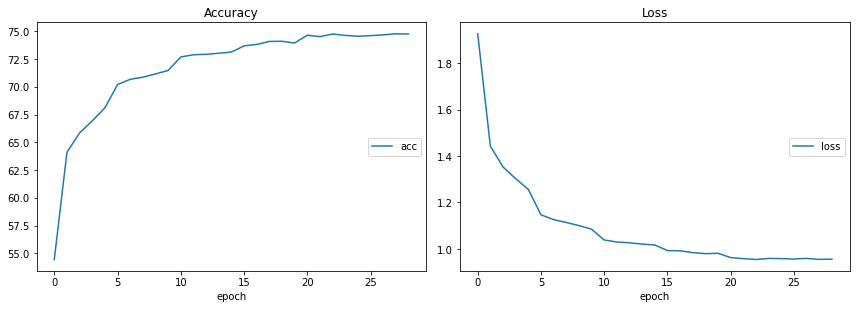

Accuracy
	acc              	 (min:   54.437, max:   74.771, cur:   74.748)
Loss
	loss             	 (min:    0.954, max:    1.927, cur:    0.955)


KeyboardInterrupt: ignored

In [40]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5,0.5)

for epoch in range(90):
    train_loss, train_accuracy = train(train_all_loader, model, criterion, optimizer, liveloss)
    scheduler.step()

## Save the trained model.

In [0]:
# torch.save(model, '/content/gdrive/My Drive/Kaggle/resnet152_new.pt')

## Load the trained model.

In [0]:
# model = torch.load('/content/gdrive/My Drive/Kaggle/resnet152_new.pt')

## Test model and save the result

In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
test_dataset = ImageFolder('/content/gdrive/My Drive/Kaggle/test', transforms.Compose([
            transforms.Resize(256),
            transforms.FiveCrop(224),
            transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
            transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops]))
        ]))
test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=64, shuffle=False, drop_last=False,
        num_workers=8)

def test(test_loader, model):
  pred = None
  # switch to evaluate mode
  model.eval()
  with torch.no_grad():
    end = time.time()
    for i, (images, target) in enumerate(test_loader):
      images = images.cuda()
      bs, ncrops, c, h, w = images.size()
      # target = target.cuda(non_blocking=True)
      # compute output
      temp_output = model(images.view(-1, c, h, w))
      outputs = temp_output.view(bs, ncrops, -1).mean(1)
      _, prediction = torch.max(outputs, 1)
      # measure accuracy and record loss
      pred = prediction if pred is None else torch.cat([pred, prediction])
  return pred

In [0]:
test_y = test(test_loader, model)

In [0]:
# Create and write submission csv file
import csv
with open('./submissionfile_resnet152_new.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(["Filename", "Label"])
  for i in range(10000):
      writer.writerow([test_dataset.samples[i][0].split('/')[-1].replace('JPEG','jpeg'), str(int(test_y[i]))])

In [0]:
# Check macro F1-score for the validation set
from sklearn.metrics import f1_score

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X = X.cuda(non_blocking=True)
            y = y.cuda(non_blocking=True)
          # compute output
            output = model(X)
            y_pred = F.log_softmax(output, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())
            
    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)


In [67]:
val_ypred, y_val = evaluate(model, val_loader)
val_f1 = f1_score(y_val, val_ypred, average='macro')
print(val_f1)

0.8109558300984665
